In [1]:
%%html
<img src="precision-recall-92.png" width="40%">

In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow_graph_in_jupyter import show_graph

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import seaborn as sns
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "fashion_mnist_fig", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=600)

In [3]:
 print(tf.__version__) 

1.13.0-rc2


In [4]:
# To plot images
def plot_images(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [103]:
# To plot confusion matrix
# Source: https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7/
def cm_analysis(y_true, y_pred, filename, labels, ymap=None, figsize=(10,10)):
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, annot_kws={"size": 14})
    plt.savefig(filename)

In [7]:
zalando_data_train = pd.read_csv('fashion-mnist_train.csv')
zalando_data_test = pd.read_csv('fashion-mnist_test.csv')

In [8]:
y_train_raw = zalando_data_train['label'].values
print(y_train_raw.shape)
X_train_raw = zalando_data_train.drop('label', axis=1).values
print(X_train_raw.shape)
y_test_raw = zalando_data_test['label'].values
print(y_test_raw.shape)
X_test_raw = zalando_data_test.drop('label', axis=1).values
print(X_test_raw.shape)

(60000,)
(60000, 784)
(10000,)
(10000, 784)


In [9]:
y_train = y_train_raw
X_train = X_train_raw
y_test = y_test_raw
X_test = X_test_raw

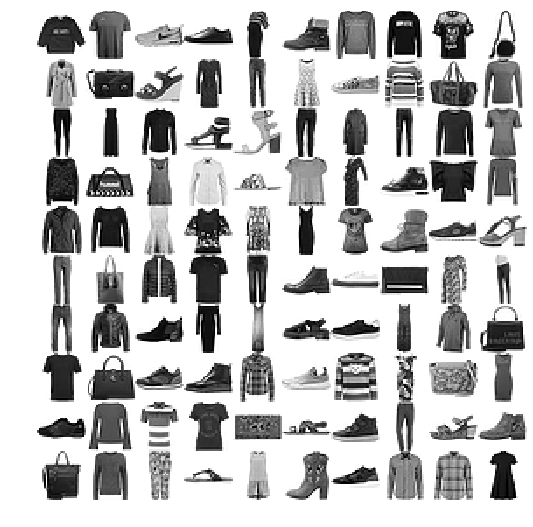

In [10]:
# show some images
plt.figure(figsize=(9,9))
example_images = np.r_[X_train[:12000:600], X_train[13000:30600:600], X_train[30600:60000:590]]
plot_images(example_images, images_per_row=10)
# save_fig("more_images_plot")
plt.show()

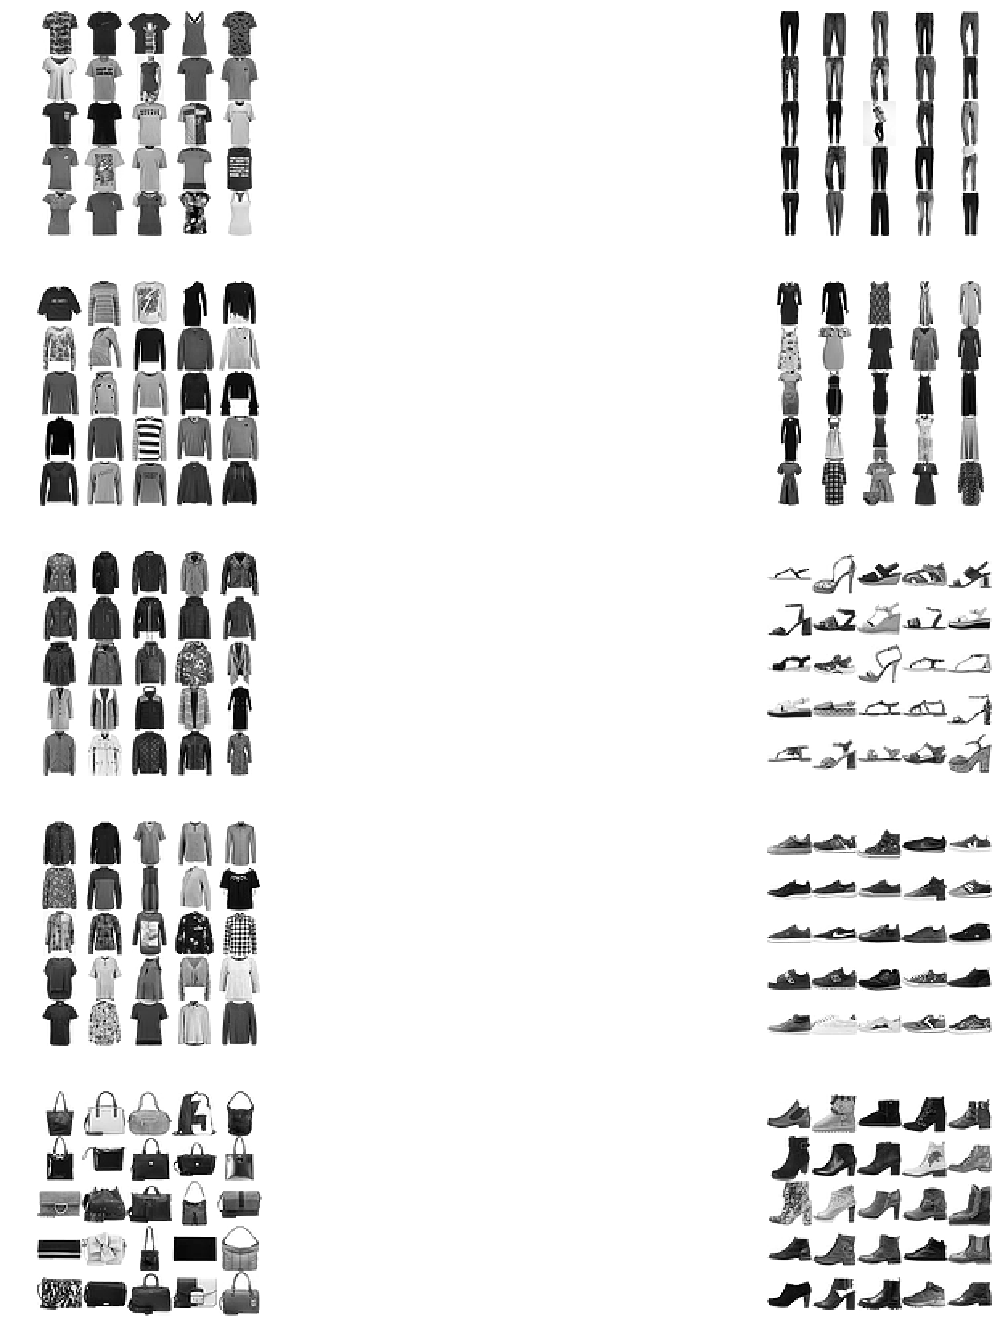

In [11]:
# plot images for each label
X_0 = X_train[(y_train == 0)]
X_1 = X_train[(y_train == 1)]
X_2 = X_train[(y_train == 2)]
X_3 = X_train[(y_train == 3)]
X_4 = X_train[(y_train == 4)]
X_5 = X_train[(y_train == 5)]
X_6 = X_train[(y_train == 6)]
X_7 = X_train[(y_train == 7)]
X_8 = X_train[(y_train == 8)]
X_9 = X_train[(y_train == 9)]

plt.figure(figsize=(24,24))
plt.subplot(521); plot_images(X_0[:25], images_per_row=5)
plt.subplot(522); plot_images(X_1[:25], images_per_row=5)
plt.subplot(523); plot_images(X_2[:25], images_per_row=5)
plt.subplot(524); plot_images(X_3[:25], images_per_row=5)
plt.subplot(525); plot_images(X_4[:25], images_per_row=5)
plt.subplot(526); plot_images(X_5[:25], images_per_row=5)
plt.subplot(527); plot_images(X_6[:25], images_per_row=5)
plt.subplot(528); plot_images(X_7[:25], images_per_row=5)
plt.subplot(529); plot_images(X_8[:25], images_per_row=5)
plt.subplot(5,2,10); plot_images(X_9[:25], images_per_row=5)
# save_fig("images_for_each_label")
plt.show()

## Pre-processing

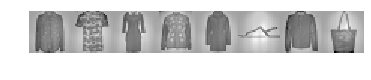

In [13]:
plot_images(X_train_scaled[2:10])

## Linear Classifier

In [57]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=150, random_state=42, tol=0.01)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=150,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.01,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [105]:
y_train_pred = sgd_clf.predict(X_train)
y_test_pred = sgd_clf.predict(X_test)

print("Training Accuracy",(y_train_pred == y_train).mean())
print("Test Accuracy",(y_test_pred == y_test).mean())

Training Accuracy 0.8507833333333333
Test Accuracy 0.8304


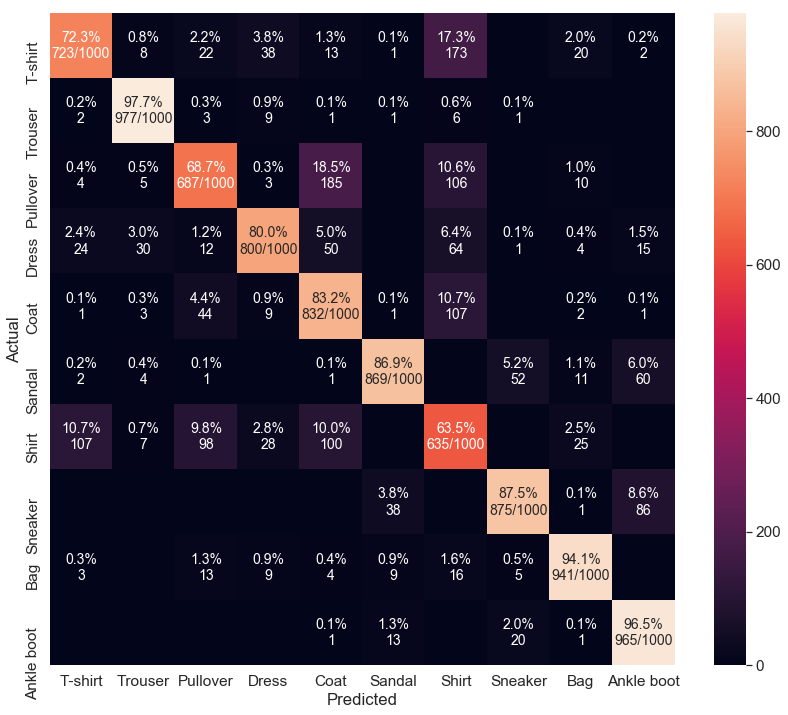

In [104]:
cm_analysis(y_test, y_test_pred, filename="confusion_matrix_SGD_test",
            labels= sgd_clf.classes_,
            ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",
                    7:"Sneaker",8:"Bag",9:"Ankle boot"},
            figsize=(14,12))

### Linear Classifier with scaling as pre-processing

In [106]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled = scaler.fit_transform(X_test.astype(np.float64))

In [107]:
sgd_clf.fit(X_train_scaled, y_train)
y_train_pred = sgd_clf.predict(X_train_scaled)
y_test_pred = sgd_clf.predict(X_test_scaled)

print("Training Accuracy",(y_train_pred == y_train).mean())
print("Test Accuracy",(y_test_pred == y_test).mean())

Training Accuracy 0.8457333333333333
Test Accuracy 0.8388


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


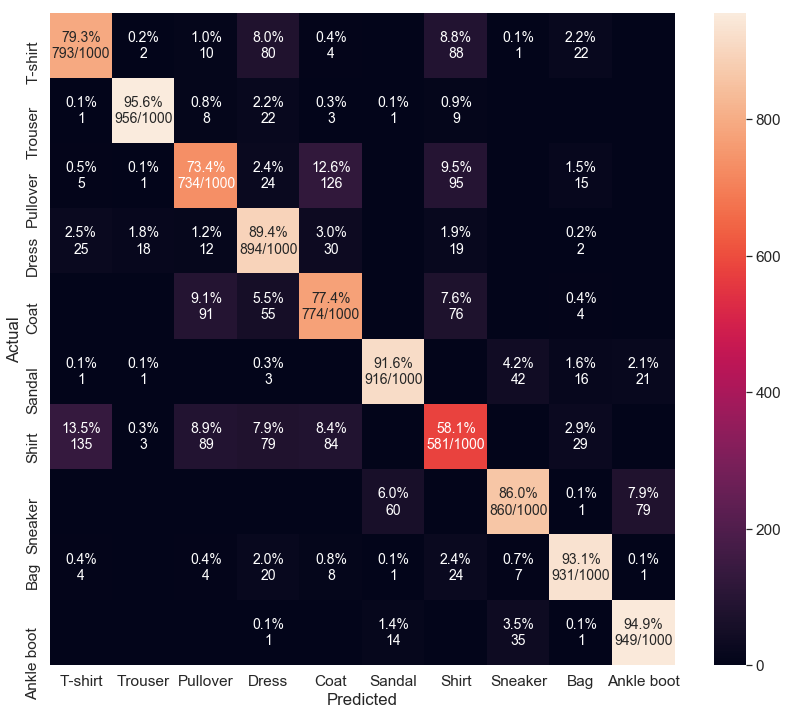

In [108]:
cm_analysis(y_test, y_test_pred, filename="confusion_matrix_SGD_test",
            labels= sgd_clf.classes_,
            ymap={0:"T-shirt", 1:"Trouser", 2:"Pullover",3:"Dress",4:"Coat",5:"Sandal",6:"Shirt",
                    7:"Sneaker",8:"Bag",9:"Ankle boot"},
            figsize=(14,12))

## SVM Classifier

## Decision Tree Classifier (Random Forest)

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier

# ovo_clf = OneVsOneClassifier(RandomForestClassifier(random_state=42)) # overfitting 
ovo_clf = OneVsOneClassifier(RandomForestClassifier(random_state=42, max_depth = 20))
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          n_jobs=None)

In [20]:
y_train_pred = ovo_clf.predict(X_train)
conf_mx_train = confusion_matrix(y_train, y_train_pred)
row_sums_train = conf_mx_train.sum(axis=1, keepdims=True)
norm_conf_mx_train = 100*(conf_mx_train / row_sums_train)

y_test_pred = ovo_clf.predict(X_test)
conf_mx_test = confusion_matrix(y_test, y_test_pred)
row_sums_test = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx_test = 100*(conf_mx_test / row_sums_test)

float_formatter = lambda x: "%.0f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
print("train","\n", norm_conf_mx_train)
print("Training Accuracy",(y_train_pred == y_train).mean())
print("test","\n", norm_conf_mx_test)
print("Test Accuracy",(y_test_pred == y_test).mean())

train 
 [[99 0 0 0 0 0 0 0 0 0]
 [0 100 0 0 0 0 0 0 0 0]
 [0 0 99 0 1 0 0 0 0 0]
 [0 0 0 99 0 0 0 0 0 0]
 [0 0 1 0 99 0 1 0 0 0]
 [0 0 0 0 0 99 0 1 0 0]
 [1 0 1 0 1 0 97 0 0 0]
 [0 0 0 0 0 0 0 100 0 0]
 [0 0 0 0 0 0 0 0 100 0]
 [0 0 0 0 0 0 0 0 0 100]]
Trainning Accuracy 0.9906666666666667
test 
 [[84 0 1 3 0 0 10 0 1 0]
 [0 97 0 2 0 0 0 0 0 0]
 [1 0 79 1 10 0 8 0 1 0]
 [3 1 1 90 2 0 3 0 0 0]
 [0 0 10 4 78 0 8 0 0 0]
 [0 0 0 0 0 94 0 4 1 1]
 [18 0 10 2 8 0 60 0 1 0]
 [0 0 0 0 0 3 0 92 0 6]
 [0 0 1 0 0 0 1 0 98 0]
 [0 0 0 0 0 1 0 6 0 93]]
Test Accuracy 0.8631


In [ ]:
plt.matshow(norm_conf_mx_test,vmin=0, vmax=100)
plt.colorbar()
# save_fig("norm_conf_mx_train")
plt.show()

<p> Decision tree overfitting?? too high accuracy for training set. (max_depth = 20)

## Neural Nets

In [22]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [23]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "."    
logdir = "{}//run-{}//".format(root_logdir, now)

In [69]:
#define validation and training sets
X_test = X_test.astype(np.int32)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:100], X_train[100:]
y_valid, y_train = y_train[:100], y_train[100:]


n_inputs = 784  # number of features (8 in this case)
n_hidden1 = 147   # half of the book's number - size of network choose as we wish 300 too large for 8 input
n_hidden2 = 70   # half of the book's number  
# dedfine more hidden layers
n_hidden3 = 50
n_outputs = 10 # have something reasonable for data (4) but need reasonable ones

tf.reset_default_graph()   # reset graph

# construvtion of tensor flow x variable that looks like data - matrrix of unknonw size just know 8 features
# y place holder for output
# auxialrry variable 
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
a = tf.placeholder(tf.float32,shape=(None),name='a')


summary1 = tf.reduce_mean(a, name="summary1")

#layer of network takes input of neurones  
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z
 
#define network here add layers
#test with 3 and 4 and test the accuracy - want more accurate - decrease then increase. if decreasing doesnt increase accuracy 
#then increasing wont help

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
    hidden3 = neuron_layer(hidden2, n_hidden3, name="hidden3", activation=tf.nn.relu)
    logits  = neuron_layer(hidden3, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

#learning rate - change if have problems with convergence or other errors
learning_rate =1e-1
with tf.name_scope("train"):
    optimizer = tf.train.AdagradOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

#define accuracy 
with tf.name_scope("accuracy"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

#leave this
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [85]:
from random import randint
n_epochs = 100   # a quarter of the book's number # how many iterations optimiser does - 5 is too few
batch_size = 100    # how many pieces data is devided into

init = tf.global_variables_initializer()
saver = tf.train.Saver()


summary2 = tf.summary.scalar('Accuracy', summary1)
file_writer = tf.summary.FileWriter(logdir , tf.get_default_graph())

with tf.Session() as sess:
    init.run()
    acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
    print("Val accuracy init:", acc_val)
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)
        
        summary_str = summary2.eval(feed_dict={a: acc_val })
        file_writer.add_summary(summary_str, epoch)
   
    saver.save(sess, "./fashion_mnist_dnn_model.ckpt")   

Val accuracy init: 0.14
0 Batch accuracy: 0.53 Val accuracy: 0.44
1 Batch accuracy: 0.59 Val accuracy: 0.46
2 Batch accuracy: 0.6 Val accuracy: 0.49
3 Batch accuracy: 0.61 Val accuracy: 0.48
4 Batch accuracy: 0.63 Val accuracy: 0.56
5 Batch accuracy: 0.71 Val accuracy: 0.57
6 Batch accuracy: 0.76 Val accuracy: 0.58
7 Batch accuracy: 0.71 Val accuracy: 0.55
8 Batch accuracy: 0.74 Val accuracy: 0.55
9 Batch accuracy: 0.78 Val accuracy: 0.61
10 Batch accuracy: 0.71 Val accuracy: 0.63
11 Batch accuracy: 0.71 Val accuracy: 0.61
12 Batch accuracy: 0.77 Val accuracy: 0.6
13 Batch accuracy: 0.75 Val accuracy: 0.62
14 Batch accuracy: 0.81 Val accuracy: 0.6
15 Batch accuracy: 0.78 Val accuracy: 0.58
16 Batch accuracy: 0.74 Val accuracy: 0.63
17 Batch accuracy: 0.82 Val accuracy: 0.6
18 Batch accuracy: 0.71 Val accuracy: 0.61
19 Batch accuracy: 0.76 Val accuracy: 0.61
20 Batch accuracy: 0.75 Val accuracy: 0.64
21 Batch accuracy: 0.74 Val accuracy: 0.62
22 Batch accuracy: 0.8 Val accuracy: 0.63
23

In [86]:
with tf.Session() as sess:                         
    saver.restore(sess, "./fashion_mnist_dnn_model.ckpt")   
    Z = logits.eval(feed_dict={X: X_test})
    y_dnn_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./fashion_mnist_dnn_model.ckpt


In [87]:
conf_mx_test = confusion_matrix(y_test, y_dnn_pred)
row_sums_test = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx_test = 100*(conf_mx_test / row_sums_test)

float_formatter = lambda x: "%.0f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

print("test","\n", norm_conf_mx_test)
print((y_dnn_pred == y_test).mean())

test 
 [[77 0 3 6 0 0 13 0 1 0]
 [0 94 1 3 0 0 1 0 0 0]
 [0 0 72 2 12 0 13 0 1 0]
 [2 1 2 88 3 0 4 0 0 0]
 [0 0 9 3 78 0 10 0 0 0]
 [0 0 0 0 0 89 0 5 1 4]
 [15 0 10 4 7 0 60 0 2 0]
 [0 0 0 0 0 4 0 91 0 6]
 [0 0 2 1 0 0 4 0 92 1]
 [0 0 0 0 0 1 0 4 0 94]]
0.8353


## CNN 

In [24]:
# Building CNN architecture
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 4  
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 8 
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = 8

n_fc1 = 32 
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    
file_writer = tf.summary.FileWriter(logdir , tf.get_default_graph())  # for TensorBoard

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [25]:
# Data preparation
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
X_train.shape

(55000, 784)

In [26]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [28]:
# Trainning CNN model
n_epochs = 30
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)         
    saver.save(sess, "./fashion_mnist_cnn_model.ckpt")
        
file_writer.close() # for TensorBoard

0 Last batch accuracy: 0.87 Test accuracy: 0.8443
1 Last batch accuracy: 0.8 Test accuracy: 0.8674
2 Last batch accuracy: 0.85 Test accuracy: 0.8711
3 Last batch accuracy: 0.94 Test accuracy: 0.8836
4 Last batch accuracy: 0.93 Test accuracy: 0.8839
5 Last batch accuracy: 0.97 Test accuracy: 0.8887
6 Last batch accuracy: 0.92 Test accuracy: 0.8909
7 Last batch accuracy: 0.93 Test accuracy: 0.8953
8 Last batch accuracy: 0.89 Test accuracy: 0.8968
9 Last batch accuracy: 0.95 Test accuracy: 0.8975
10 Last batch accuracy: 0.89 Test accuracy: 0.8962
11 Last batch accuracy: 0.91 Test accuracy: 0.8976
12 Last batch accuracy: 0.88 Test accuracy: 0.8952
13 Last batch accuracy: 0.96 Test accuracy: 0.9024
14 Last batch accuracy: 0.97 Test accuracy: 0.9013
15 Last batch accuracy: 0.93 Test accuracy: 0.8996
16 Last batch accuracy: 0.93 Test accuracy: 0.9017
17 Last batch accuracy: 0.86 Test accuracy: 0.9063
18 Last batch accuracy: 0.93 Test accuracy: 0.9036
19 Last batch accuracy: 0.92 Test accuracy

<p> Results:
<p> 0 Last batch accuracy: 0.71 Test accuracy: 0.8369
<p> 1 Last batch accuracy: 0.92 Test accuracy: 0.8664
<p> 2 Last batch accuracy: 0.82 Test accuracy: 0.8758
<p> 3 Last batch accuracy: 0.86 Test accuracy: 0.8801
<p> 4 Last batch accuracy: 0.94 Test accuracy: 0.8863
<p> 5 Last batch accuracy: 0.92 Test accuracy: 0.886
<p> 6 Last batch accuracy: 0.95 Test accuracy: 0.8916
<p> 7 Last batch accuracy: 0.88 Test accuracy: 0.896
<p> 8 Last batch accuracy: 0.95 Test accuracy: 0.8965
<p> 9 Last batch accuracy: 0.9 Test accuracy: 0.897

In [29]:
# Validation on test set
with tf.Session() as sess:                         
    saver.restore(sess, "./fashion_mnist_cnn_model.ckpt")   
    Z = logits.eval(feed_dict={X: X_test})
    y_cnn_pred = np.argmax(Z, axis=1)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./fashion_mnist_cnn_model.ckpt


In [30]:
# Confusion Matrix for test set
conf_mx_test = confusion_matrix(y_test, y_cnn_pred)
row_sums_test = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx_test = 100*(conf_mx_test / row_sums_test)



print("test","\n", norm_conf_mx_test)
print((y_cnn_pred == y_test).mean())

test 
 [[90 0 1 2 0 0 6 0 0 0]
 [0 98 0 2 0 0 0 0 0 0]
 [4 0 83 2 4 0 7 0 1 0]
 [2 1 0 94 1 0 2 0 0 0]
 [0 0 7 6 81 0 7 0 0 0]
 [0 0 0 0 0 97 0 2 0 1]
 [19 0 4 5 4 0 69 0 0 0]
 [0 0 0 0 0 1 0 95 0 4]
 [0 0 0 0 0 0 1 0 98 0]
 [0 0 0 0 0 0 0 2 0 97]]
0.9009


In [ ]:
plt.matshow(norm_conf_mx_test,vmin=0, vmax=100)
plt.colorbar()
# save_fig("norm_conf_mx_train")
plt.show()

In [ ]:
from tensorflow_graph_in_jupyter import show_graph
show_graph(tf.get_default_graph())

## RNN

In [161]:
import tensorflow as tf

reset_graph()

n_steps = 28
n_inputs = 28
n_neurons = 150 
n_outputs = 10

learning_rate = 0.001

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)
outputs, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

logits = tf.layers.dense(states, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
# prediction = tf.argmax(tf.nn.softmax(logits), 1) # not in book
prediction = tf.argmax(logits, 1)

loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)
correct = tf.nn.in_top_k(logits, y, 1) # check if the prediction is corret [True, False]
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [162]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("FashionMnist-data")

X_test = mnist.test.images.reshape((-1, n_steps, n_inputs))
y_test = mnist.test.labels

Extracting FashionMnist-data/train-images-idx3-ubyte.gz
Extracting FashionMnist-data/train-labels-idx1-ubyte.gz
Extracting FashionMnist-data/t10k-images-idx3-ubyte.gz
Extracting FashionMnist-data/t10k-labels-idx1-ubyte.gz


In [164]:
import time
n_epochs = 10 # was 100
batch_size = 150
start_time = time.time()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            # print(iteration,end=' ')
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Test accuracy:", acc_test)       
    saver.save(sess, "./fashion_mnist_rnn_model.ckpt")

print("--- %s seconds ---" % (time.time() - start_time))

0 Test accuracy: 0.7962
1 Test accuracy: 0.8149
2 Test accuracy: 0.8262
3 Test accuracy: 0.8335
4 Test accuracy: 0.8429
5 Test accuracy: 0.8333
6 Test accuracy: 0.8426
7 Test accuracy: 0.8494
8 Test accuracy: 0.8477
9 Test accuracy: 0.8537
--- 65.54042100906372 seconds ---


In [174]:
with tf.Session() as sess:                         
    saver.restore(sess, "./fashion_mnist_rnn_model.ckpt") 
    prediction = tf.argmax(logits, axis=1)
    y_rnn_pred = sess.run(prediction, feed_dict={X: X_test})
#     Z = logits.eval(feed_dict={X: X_test})
#     y_rnn_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./fashion_mnist_rnn_model.ckpt


In [176]:
conf_mx_test = confusion_matrix(y_test, y_rnn_pred)
row_sums_test = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx_test = 100*(conf_mx_test / row_sums_test)

float_formatter = lambda x: "%.0f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

print("test","\n", norm_conf_mx_test)
print((y_rnn_pred == y_test).mean())

test 
 [[84 0 1 5 0 0 7 0 2 0]
 [0 96 0 3 0 0 0 0 0 0]
 [2 0 67 2 23 0 4 0 2 0]
 [4 1 1 88 3 0 3 0 1 0]
 [0 0 5 4 86 0 4 0 1 0]
 [0 0 0 0 0 96 0 2 1 1]
 [18 0 8 4 12 0 53 0 4 0]
 [0 0 0 0 0 5 0 91 0 4]
 [0 0 0 1 0 1 0 0 98 0]
 [0 0 0 0 0 1 0 4 0 94]]
0.8537


## Confusion Matrix

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx_train = confusion_matrix(y_train, y_train_pred)
conf_mx_train

In [ ]:
y_test_pred = cross_val_predict(sgd_clf, X_test_scaled, y_test, cv=3)
conf_mx_test = confusion_matrix(y_test, y_test_pred)
conf_mx_test

In [ ]:
row_sums_train = conf_mx_train.sum(axis=1, keepdims=True)
row_sums_test = conf_mx_test.sum(axis=1, keepdims=True)
norm_conf_mx_train = 100*(conf_mx_train / row_sums_train)
norm_conf_mx_test = 100*(conf_mx_test / row_sums_test)
float_formatter = lambda x: "%.0f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
print("train","\n", norm_conf_mx_train)
print("test","\n", norm_conf_mx_test)

In [ ]:
# train
plt.matshow(norm_conf_mx_train,vmin=0, vmax=100)
plt.colorbar()
# save_fig("norm_conf_mx_train")
plt.show()

In [ ]:
# test
plt.matshow(norm_conf_mx_test,vmin=0, vmax=100)
plt.colorbar()
# save_fig("norm_conf_mx_test")
plt.show()

In [ ]:
# show errors for training set
norm_conf_mx_train_= norm_conf_mx_train
np.fill_diagonal(norm_conf_mx_train_,0)
plt.matshow(norm_conf_mx_train_)
plt.colorbar()
# save_fig("norm_conf_mx_train_errors")
plt.show()

In [ ]:
# show errors for test set
norm_conf_mx_test_= norm_conf_mx_test
np.fill_diagonal(norm_conf_mx_test_,0)
plt.matshow(norm_conf_mx_test_)
plt.colorbar()
# save_fig("norm_conf_mx_test_errors")
plt.show()

## Error Analysis - training set

In [ ]:
# show errors for training set
norm_conf_mx_train_= norm_conf_mx_train
np.fill_diagonal(norm_conf_mx_train_,0)
plt.matshow(norm_conf_mx_train_)
plt.colorbar()
# save_fig("norm_conf_mx_train_errors")
plt.show()

In [ ]:
# more errors happend to label 0,2,4,6 
X_0 = X_train[(y_train == 0)]
X_2 = X_train[(y_train == 2)]
X_4 = X_train[(y_train == 4)]
X_6 = X_train[(y_train == 6)]

plt.figure(figsize=(9,9))
plt.subplot(221); plot_images(X_0[:25], images_per_row=5)
plt.subplot(222); plot_images(X_2[:25], images_per_row=5)
plt.subplot(223); plot_images(X_4[:25], images_per_row=5)
plt.subplot(224); plot_images(X_6[:25], images_per_row=5)
# save_fig("images_for_labels_0&2&4&6")

In [ ]:
# error analysis : label 2 and 4
cl_a, cl_b = 2, 4
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(7,9))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_2&4")
plt.show()

In [ ]:
# error analysis : label 6 and 0
cl_a, cl_b = 6, 0
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(9,9))
plt.subplot(221); plot_images(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_images(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_images(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_images(X_bb[:25], images_per_row=5)
# save_fig("error_analysis_images_plot_6&0")
plt.show()

In [ ]:
# error analysis : label 6 and 0
cl_a, cl_b = 2, 8
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(9,9))
plt.subplot(221); plot_images(X_aa[:16], images_per_row=4)
plt.subplot(222); plot_images(X_ab[:16], images_per_row=4)
plt.subplot(223); plot_images(X_ba[:16], images_per_row=4)
plt.subplot(224); plot_images(X_bb[:16], images_per_row=4)
# save_fig("error_analysis_images_plot_2&8")
plt.show()

# Error Analysis - test set

In [ ]:
# show errors for test set
norm_conf_mx_test_= norm_conf_mx_test
np.fill_diagonal(norm_conf_mx_test_,0)
plt.matshow(norm_conf_mx_test_)
plt.colorbar()
# save_fig("norm_conf_mx_test_errors")
plt.show()

In [ ]:
# more errors happend to label 0,2,4,6 
X_0 = X_test[(y_test == 0)]
X_2 = X_test[(y_test == 2)]
X_4 = X_test[(y_test == 4)]
X_6 = X_test[(y_test == 6)]

plt.figure(figsize=(9,9))
plt.subplot(221); plot_images(X_0[:25], images_per_row=5)
plt.subplot(222); plot_images(X_2[:25], images_per_row=5)
plt.subplot(223); plot_images(X_4[:25], images_per_row=5)
plt.subplot(224); plot_images(X_6[:25], images_per_row=5)
# save_fig("images_for_labels_0&2&4&6")
plt.show()

In [ ]:
# error analysis : label 2 and 4
cl_a, cl_b = 2, 4
X_aa = X_test[(y_test == cl_a) & (y_test_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_pred == cl_b)]

plt.figure(figsize=(7,9))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_2&4")
plt.show()

In [ ]:
# error analysis : label 6 and 0
cl_a, cl_b = 6, 0
X_aa = X_test[(y_test == cl_a) & (y_test_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_pred == cl_b)]

plt.figure(figsize=(7,9))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_6&0")
plt.show()

In [ ]:
# error analysis : label 6 and 0
cl_a, cl_b = 2, 8
X_aa = X_test[(y_test == cl_a) & (y_test_pred == cl_a)]
X_ab = X_test[(y_test == cl_a) & (y_test_pred == cl_b)]
X_ba = X_test[(y_test == cl_b) & (y_test_pred == cl_a)]
X_bb = X_test[(y_test == cl_b) & (y_test_pred == cl_b)]

plt.figure(figsize=(7,9))
plt.subplot(221); plot_images(X_aa[:9], images_per_row=3)
plt.subplot(222); plot_images(X_ab[:9], images_per_row=3)
plt.subplot(223); plot_images(X_ba[:9], images_per_row=3)
plt.subplot(224); plot_images(X_bb[:9], images_per_row=3)
# save_fig("error_analysis_images_plot_2&8")
plt.show()